## Toxic comment multi-class classification using fine-tuned T5 model

#### 1. Dataset

Jigsaw toxic comments data with multi-class labels

https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge



#### 2. Importing libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Deep Learning Framework - Using PyTorch here
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Hugging Face Transformers
#!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, T5Tokenizer, T5ForConditionalGeneration

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, hamming_loss, accuracy_score

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # if using CUDA

# Setup device use gpu cuda if avaible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")#

# Configuration (Adjust these as needed)
MODEL_NAME = 't5-small'
MAX_LENGTH = 128 # Max sequence length  (adjust based on EDA)
BATCH_SIZE = 16 # Adjust based on GPU memory
EPOCHS = 3 # Number of training epochs
LEARNING_RATE = 2e-5 # Common learning rate

Using device: cuda


#### 3. Loading Data

In [22]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/datasets/jigsaw_multilabel.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
print(data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


#### 4. Exploratory Data Analysis (EDA)

Label Distribution:
               count  percentage
toxic          15294    9.584448
severe_toxic    1595    0.999555
obscene         8449    5.294822
threat           478    0.299553
insult          7877    4.936361
identity_hate   1405    0.880486


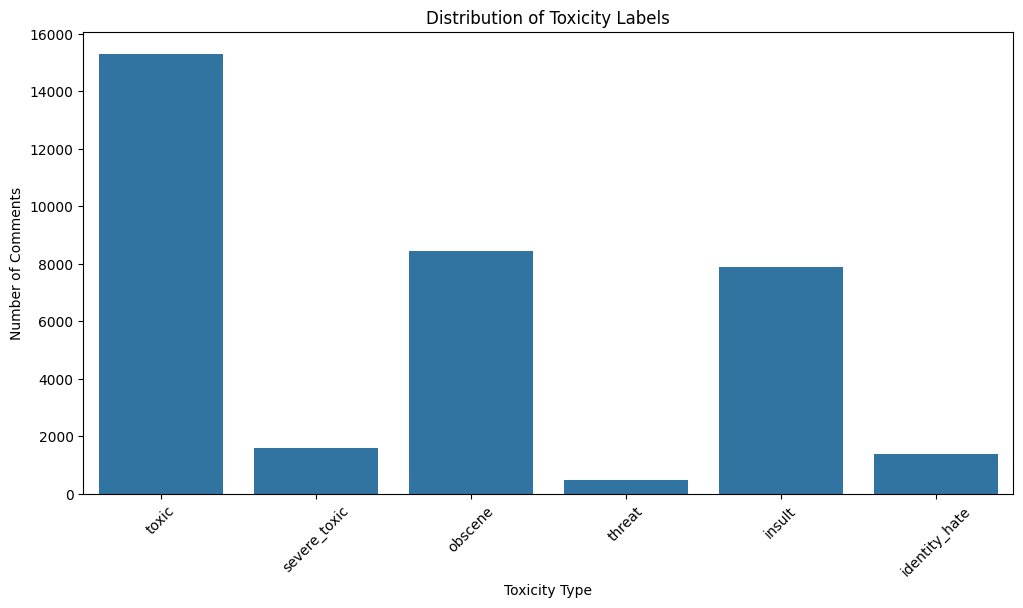


Number of comments with NO toxicity labels: 143346 (89.83%)


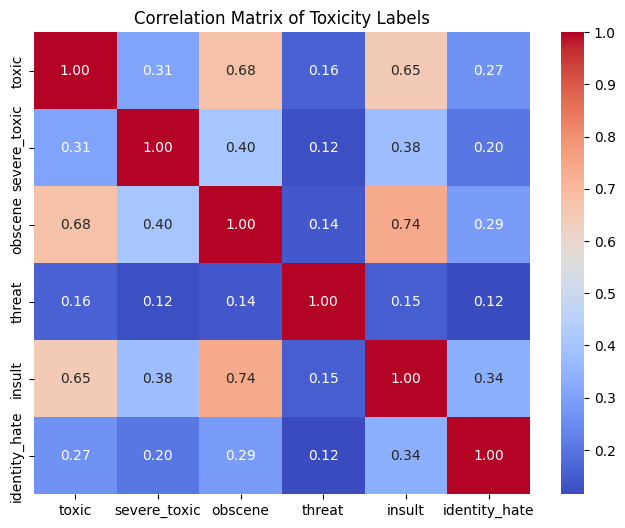

In [24]:
# Define target labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Calculate label counts and percentages
label_counts = data[label_cols].sum()
label_percentages = (label_counts / len(data)) * 100

# Create a DataFrame for plotting
label_stats_df = pd.DataFrame({'count': label_counts, 'percentage': label_percentages})
print("Label Distribution:")
print(label_stats_df)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=label_stats_df.index, y=label_stats_df['count'])
plt.title('Distribution of Toxicity Labels')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.xticks(rotation=45)
plt.show()

# Check for comments with no labels (clean comments)
no_label_count = len(data[data[label_cols].sum(axis=1) == 0])
print(f"\nNumber of comments with NO toxicity labels: {no_label_count} ({no_label_count / len(data) * 100:.2f}%)")

# Multi-label Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(data[label_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Toxicity Labels')
plt.show()
# Observation: High correlation between 'toxic' and 'obscene'/'insult'. 'Severe toxic' implies 'toxic'.

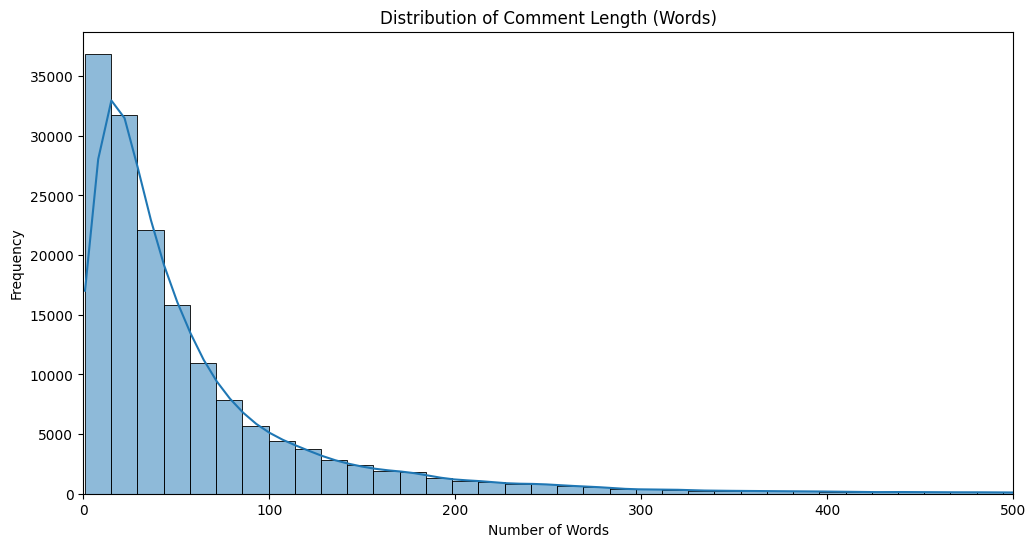


Comment Length Statistics (Words):
count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_length, dtype: float64


In [25]:
data['comment_length'] = data['comment_text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(12, 6))
sns.histplot(data['comment_length'], bins=100, kde=True)
plt.title('Distribution of Comment Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# Limit x-axis for better visualization if needed
plt.xlim(0, 500)
plt.show()

print("\nComment Length Statistics (Words):")
print(data['comment_length'].describe())
# Observation: Most comments are well below 512 tokens, but some are longer. MAX_LENGTH=128 or 256 might be reasonable start.

#### 5. Data Preprocessing and Tokenization

##### 5.1 Text Cleaning

In [26]:
def clean_text(text):
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Basic handling of common issues if needed
    text = text.lower()
    return text

# Apply cleaning (demonstrative - may skip depending on BERT variant)
data['comment_text_cleaned'] = data['comment_text'].apply(clean_text)



##### 5.2 Tokenization with BERT Tokenizer

In [27]:
# tokenization
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

# Example tokenization
sample_text = "This is a sample comment for tokenization."
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    padding='max_length', # Pad to max_length
    truncation=True,      # Truncate longer sequences
    return_tensors='pt'   # Return PyTorch tensors
)

print("\nSample Tokenization:")
print(f"Text: {sample_text}")
# T5 tokenizer decode method is slightly different, it directly decodes token IDs
print(f"Tokens (decoded): {tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)}")
print(f"Input IDs: {tokens['input_ids']}")
print(f"Attention Mask: {tokens['attention_mask']}") # 1 for real tokens, 0 for padding


Sample Tokenization:
Text: This is a sample comment for tokenization.
Tokens (decoded): This is a sample comment for tokenization.
Input IDs: tensor([[  100,    19,     3,     9,  3106,  1670,    21, 14145,  1707,     5,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


##### 5.3 Creating Pytorch Datasets and DataLoaders

In [28]:
#Encapsulate the data and tokenization logic into a PyTorch Dataset class for efficient batch loading.
class ToxicCommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.labels[item] # This is a numpy array of shape (6,)

        # T5 input format: Prepend a task-specific prefix
        # Convert the multi-hot encoded label array into a target string
        # e.g., [0, 1, 0, 0, 1, 0] -> "severe_toxic, insult" or "clean" if all 0
        target_labels_str = [self.label_cols[i] for i, val in enumerate(target) if val == 1]
        if not target_labels_str:
            target_text = "clean"
        else:
            target_text = ", ".join(target_labels_str)


        source_text = "classify comment: " + comment

        # Tokenize source text (comment with prefix)
        source_encoding = self.tokenizer(
            source_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Tokenize target text (labels as string)
        target_encoding = self.tokenizer(
            target_text,
            add_special_tokens=True,
            max_length=self.max_len, # Using same max length for target for simplicity
            padding='max_length',
            truncation=True,
            return_attention_mask=True, # Although not strictly needed for labels in T5, good practice
            return_tensors='pt',
        )

        # T5 requires decoder_input_ids (shifted version of target_encoding['input_ids'])
        # However, the T5ForConditionalGeneration model handles this internally when
        # the 'labels' argument is provided during the forward pass.
        # So, we return the target_encoding['input_ids'] as 'labels'.

        return {
            'comment_text': comment, # Keep original for debugging
            'input_ids': source_encoding['input_ids'].flatten(),
            'attention_mask': source_encoding['attention_mask'].flatten(),
            'labels': target_encoding['input_ids'].flatten() # Target input IDs for T5 decoder
        }

# Prepare data for Dataset class
X = data['comment_text_cleaned'].values
y = data[label_cols].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1, # Use 10% for validation
    random_state=SEED,
    # Stratification is complex for multi-label, can skip or use iterative stratification if needed
)

print(f"\nTrain size: {len(X_train)}, Validation size: {len(X_val)}")

# Create Datasets
train_dataset = ToxicCommentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = ToxicCommentDataset(X_val, y_val, tokenizer, MAX_LENGTH)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers depends on your system
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Example batch check
data = next(iter(train_dataloader))
print("\nSample batch shapes:")
print("Input IDs:", data['input_ids'].shape)
print("Attention Mask:", data['attention_mask'].shape)
print("Labels:", data['labels'].shape) # Should now be the shape of target input IDs


Train size: 143613, Validation size: 15958

Sample batch shapes:
Input IDs: torch.Size([16, 128])
Attention Mask: torch.Size([16, 128])
Labels: torch.Size([16, 128])


In [29]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


#### 6. Model Definition

In [30]:
# Load the pre-trained T5 model (T5ForConditionalGeneration)
# T5ForConditionalGeneration is suitable for sequence-to-sequence tasks like generating labels.
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

# Move the model to the designated device (GPU or CPU)
model.to(device)

print("\nModel loaded successfully.")
# print(model) # Uncomment to see model architecture details


Model loaded successfully.


#### 7. Model Training

##### 7.1 Setup Optimizer and Scheduler

In [31]:
#Setup Optimizer and Scheduler
# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * EPOCHS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Optional: set a number of warmup steps (e.g., 0.1 * total_steps)
    num_training_steps=total_steps
)

# Loss function: CrossEntropyLoss with label_smoothing (optional but helpful for seq2seq)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)

##### 7.2 Training and Evaluation loop

In [33]:
#Training Loop
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, batch in enumerate(data_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device) # T5 uses 'labels' for the target sequence

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        # T5ForConditionalGeneration computes the loss internally when labels are provided
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels # Provide the target sequence as labels
        )
        loss = outputs.loss # Access the calculated loss

        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients (common practice)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step() # Update learning rate

        # Print progress (optional)
        if (i + 1) % 100 == 0:
             print(f'  Batch {i + 1}/{num_batches} | Loss: {loss.item():.4f}')


    avg_train_loss = total_loss / num_batches
    print(f"\n  Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss

#Evaluation Loop
def eval_model(model, data_loader, tokenizer, device, label_cols):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_predicted_texts = []
    all_true_texts = []
    num_batches = len(data_loader)

    # Map label strings back to indices for metric calculation later
    label_to_index = {label: i for i, label in enumerate(label_cols)}

    with torch.no_grad(): # Disable gradient calculation
        for batch in data_loader:
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device) # T5 uses 'labels' for the target sequence

            # Calculate loss during evaluation (optional, but good for monitoring)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels # Provide the target sequence as labels
            )
            loss = outputs.loss
            total_loss += loss.item()

            # Generate predictions (token IDs)
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=MAX_LENGTH, # Use the same max length as for target tokenization
                num_beams=3, # Simple greedy search for now. Experiment with higher values (e.g., 4 or 5)
                repetition_penalty=2.5, # Penalize repeated tokens
                length_penalty=1.0, # Encourage longer sequences

            )

            # Decode generated token IDs back to strings
            predicted_texts = [tokenizer.decode(gen_id, skip_special_tokens=True) for gen_id in generated_ids]
            true_texts = [tokenizer.decode(true_id, skip_special_tokens=True) for true_id in labels]

            all_predicted_texts.extend(predicted_texts)
            all_true_texts.extend(true_texts)


    avg_val_loss = total_loss / num_batches
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")

    # --- Metric Calculation based on generated text ---
    # Convert predicted and true text labels back to multi-hot encoding for standard metrics
    # This requires careful parsing of the generated text string (e.g., "toxic, insult")

    def parse_labels_from_text(text, label_mapping):
        """Parses a comma-separated string of labels into a multi-hot encoded list."""
        # Handle "clean" case
        if text.strip().lower() == "clean":
            return [0] * len(label_mapping)

        # Split the string and create the multi-hot encoding
        predicted_labels = [0] * len(label_mapping)
        for label in text.split(','):
            label = label.strip()
            # Handle potential variations in generated labels (e.g., extra spaces)
            label = label.lower().replace(" ", "_") # Convert to expected format if needed
            if label in label_mapping:
                predicted_labels[label_mapping[label]] = 1
            # Optional: Add a warning for unrecognised predicted labels
            # else:
            #     print(f"Warning: Unrecognized predicted label: {label}")

        return predicted_labels

    all_true_multihot = np.array([parse_labels_from_text(text, label_to_index) for text in all_true_texts])
    all_predicted_multihot = np.array([parse_labels_from_text(text, label_to_index) for text in all_predicted_texts])

    # Ensure dimensions match (should be len(samples) x len(label_cols))
    if all_true_multihot.shape != all_predicted_multihot.shape or all_true_multihot.shape[1] != len(label_cols):
        print("Warning: Mismatch in shapes or number of labels during metric calculation.")


    # Calculate Hamming Loss
    hamming = hamming_loss(all_true_multihot, all_predicted_multihot)
    print(f"  Hamming Loss: {hamming:.4f}")

    # Calculate Classification Report (Precision, Recall, F1 per label)
    print("\nClassification Report (parsed labels):")
    # Need to handle cases where a label might not appear in the true or predicted set
    # using zero_division=0 in classification_report
    print(classification_report(all_true_multihot, all_predicted_multihot, target_names=label_cols, zero_division=0))

    return avg_val_loss, None, hamming # Return None for ROC AUC

# Update the training loop to call the modified functions
# The training loop code remains largely the same, only the function calls change
history = {'train_loss': [], 'val_loss': [], 'val_roc_auc': [], 'val_hamming': []}

best_val_loss = float('inf') # Initialize with a high value
best_model_state = None

print("\nStarting Training...")
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    # Call modified train_epoch
    train_loss = train_epoch(
        model,
        train_dataloader,
        optimizer,
        device,
        scheduler
    )
    history['train_loss'].append(train_loss)

    print(f"\n--- Validation Epoch {epoch + 1} ---")
    # Call modified eval_model - pass tokenizer and label_cols
    val_loss, _, val_hamming = eval_model(
        model,
        val_dataloader,
        tokenizer, # Pass tokenizer
        device,
        label_cols # Pass label_cols
    )
    history['val_loss'].append(val_loss)
    history['val_hamming'].append(val_hamming)

    # Save the best model based on validation loss (lower is better)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model_state.bin')
        print(f"  ** New best model saved with Validation Loss: {best_val_loss:.4f} **")

print("\nTraining Finished.")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Load the best model state for prediction (if needed later)
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model state for prediction.")


Starting Training...

--- Epoch 1/3 ---
  Batch 100/8976 | Loss: 0.6489
  Batch 200/8976 | Loss: 0.2056
  Batch 300/8976 | Loss: 0.0974
  Batch 400/8976 | Loss: 0.0532
  Batch 500/8976 | Loss: 0.0266
  Batch 600/8976 | Loss: 0.0160
  Batch 700/8976 | Loss: 0.0123
  Batch 800/8976 | Loss: 0.0285
  Batch 900/8976 | Loss: 0.0194
  Batch 1000/8976 | Loss: 0.0369
  Batch 1100/8976 | Loss: 0.0047
  Batch 1200/8976 | Loss: 0.0051
  Batch 1300/8976 | Loss: 0.0105
  Batch 1400/8976 | Loss: 0.0127
  Batch 1500/8976 | Loss: 0.0014
  Batch 1600/8976 | Loss: 0.0046
  Batch 1700/8976 | Loss: 0.0158
  Batch 1800/8976 | Loss: 0.0206
  Batch 1900/8976 | Loss: 0.0074
  Batch 2000/8976 | Loss: 0.0167
  Batch 2100/8976 | Loss: 0.0020
  Batch 2200/8976 | Loss: 0.0086
  Batch 2300/8976 | Loss: 0.0052
  Batch 2400/8976 | Loss: 0.0024
  Batch 2500/8976 | Loss: 0.0034
  Batch 2600/8976 | Loss: 0.0042
  Batch 2700/8976 | Loss: 0.0047
  Batch 2800/8976 | Loss: 0.0068
  Batch 2900/8976 | Loss: 0.0049
  Batch 300

In [35]:
#save the trained model into google drive folder
model.save_pretrained('models/t5_jigsaw_multilabel_finetuned')
tokenizer.save_pretrained("models/t5_jigsaw_multilabel_finetuned")


('models/t5_jigsaw_multilabel_finetuned/tokenizer_config.json',
 'models/t5_jigsaw_multilabel_finetuned/special_tokens_map.json',
 'models/t5_jigsaw_multilabel_finetuned/spiece.model',
 'models/t5_jigsaw_multilabel_finetuned/added_tokens.json')